In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import plotly.offline as py
from tqdm import tqdm

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)
df_merged_clusterB = pd.read_hdf('../ds/cleaned/reduced_for_clustering.h5')
df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,min_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,No deaths,58.789954,2.345189,0.136149,2.0
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,No deaths,45.310907,2.345189,0.639968,2.0
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,No deaths,71.662763,2.345189,0.096973,0.0
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,28,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,No deaths,70.237122,2.345189,0.534650,2.0
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,All deaths,43.229167,2.345189,0.097775,1.0


# Density-based clustering

DBSCAN: start from data distribution, count #points close to each point, like a circle and overlap. Define a core points: es a point that is close to at least n points (defined by user), randomly pick a core point, assign it to a cluster. Others core points close to the 1st cluster are added (cuz the circle overlap them), go on... then add non-core point if just is close to a core point


In [89]:
stato_con_massima_povertà = df_merged_clusterB.loc[df_merged_clusterB['povertyPercentage'].idxmax()]

# Stampa le informazioni sullo stato con la più alta povertyPercentage
print("Stato con la più alta povertyPercentage:")
print(stato_con_massima_povertà[['state', 'povertyPercentage']])


Stato con la più alta povertyPercentage:
state                Mississippi
povertyPercentage           20.8
Name: 16, dtype: object


Poorest state is not anymore the New Mexico beacuse we have dropped past years, so let's analyse the Mississippi

In [90]:
col_clustering_dbscan = ['percentage_injured','density_incident_state','min_age_participants', 'percentage_injured', 'males_to_females_ratio']
df_for_dbscan = df_merged_clusterB[col_clustering_dbscan]
df_mississippi =  df_merged_clusterB[df_merged_clusterB['state'] == 'Mississippi']
df_mississippi_clustering = df_mississippi[col_clustering_dbscan]

# Standardizzazione dei dati
scaler = StandardScaler()
df_mississippi_scaled = scaler.fit_transform(df_mississippi_clustering)

/tmp/ipykernel_470553/3691990295.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



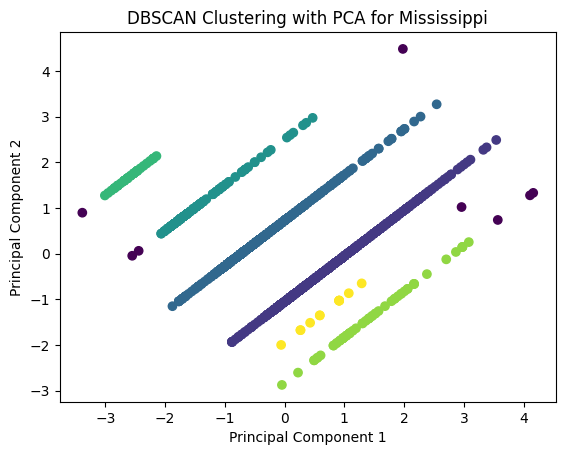

In [91]:
# priciapal component analysis
from sklearn.decomposition import PCA


#dbscan
eps = 0.5  # Distanza massima tra due campioni per essere considerati nello stesso vicinato
min_samples = 5  # Numero minimo di campioni in un vicinato per essere considerati un cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_mississippi['cluster_labels'] = dbscan.fit_predict(df_mississippi_scaled)

#pca
pca=PCA(n_components=3)
mississippi_pca = pca.fit_transform(df_mississippi_scaled)
#plt.scatter(mississippi_pca[:,0], mississippi_pca[:,1])
plt.scatter(mississippi_pca[:, 0], mississippi_pca[:, 1], c=df_mississippi['cluster_labels'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA for Mississippi')
plt.show()

Since is shit, let's try to add new indicators


In [94]:
df_merged_clusterB['avg_incident_density_per_district'] = df_merged_clusterB.groupby('congressional_district')['density_incident_state'].transform('mean')

df_merged_clusterB.head()

,date,state,city_or_county,latitude,longitude,congressional_district,participant_age_group1,participant_gender1,min_age_participants,n_participants_child,n_participants_teen,n_females,n_killed,n_injured,n_arrested,n_unharmed,incident_characteristics1,povertyPercentage,party,candidatevotes,totalvotes,ratio_killed,death_level,percentage_injured,unharmed_ratio,density_incident_state,males_to_females_ratio,percentage_young_participants,average_incident_density_per_district
0,2014-01-01,Arkansas,Pine Bluff,34.2291,-91.9779,4,Adult 18+,Male,26,0,0,0,0,1,0,1,Shot - Wounded/Injured,16.8,REPUBLICAN,110789.0,206131.0,0.0,No deaths,58.789954,2.345189,0.136149,2.0,NaN,0.332950
1,2014-01-01,California,Bakersfield,35.3229,-119.0380,23,Adult 18+,Male,28,0,0,0,0,2,0,0,Shot - Wounded/Injured,14.5,REPUBLICAN,100317.0,134043.0,0.0,No deaths,45.310907,2.345189,0.639968,2.0,NaN,0.593119
2,2014-01-01,Iowa,Iowa City,41.6611,-91.5302,2,Adult 18+,Female,35,0,0,2,0,1,0,1,other,10.1,DEMOCRAT,143431.0,273329.0,0.0,No deaths,71.662763,2.345189,0.096973,0.0,NaN,0.316859
3,2014-01-01,New York,Brooklyn,40.6505,-73.9573,9,Adult 18+,Male,28,0,0,1,0,3,0,0,Shot - Wounded/Injured,13.4,DEMOCRAT,70997.0,101606.0,0.0,No deaths,70.237122,2.345189,0.534650,2.0,NaN,0.416183
4,2014-01-01,Colorado,Grand Junction,39.0496,-108.5250,3,Adult 18+,Male,47,0,0,0,1,0,0,0,"Shot - Dead (murder, accidental, suicide)",10.2,REPUBLICAN,163011.0,281141.0,1.0,All deaths,43.229167,2.345189,0.097775,1.0,0.0,0.271355


In [93]:
state_df = df_merged_clusterB[df_merged_clusterB['state'] == 'Illinois']

# Seleziona le colonne rilevanti per il clustering
selected_columns = ['latitude', 'longitude']
X = state_df[selected_columns]

# Standardizza i dati Z-score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Esegui DBSCAN
eps = 0.2  # Sostituisci con il valore appropriato
min_samples = 5  # Sostituisci con il valore appropriato
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
state_df['cluster'] = dbscan.fit_predict(X_scaled)

# Analisi dei parametri di clustering
n_clusters = len(set(state_df['cluster'])) - (1 if -1 in state_df['cluster'] else 0)
print(f'Number of clusters: {n_clusters}')

# Caratterizzazione e interpretazione dei cluster
cluster_stats = state_df.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'n_killed': 'sum',
    'n_injured': 'sum',
    'n_participants': 'sum'
})

# Visualizzazione dei risultati
for cluster_id, row in cluster_stats.iterrows():
    print(f'Cluster {cluster_id}:')
    print(f'  Centroid: ({row["latitude"]}, {row["longitude"]})')
    print(f'  Number of killed: {row["n_killed"]}')
    print(f'  Number of injured: {row["n_injured"]}')
    print(f'  Number of participants: {row["n_participants"]}')
    print('---')

# Visualizzazione della distribuzione dei cluster sulla mappa (usa solo a scopo illustrativo)
plt.scatter(state_df['longitude'], state_df['latitude'], c=state_df['cluster'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Number of clusters: 25


/tmp/ipykernel_470553/1218902845.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyError: "Column(s) ['n_participants'] do not exist"

Without latitude and longitude

/tmp/ipykernel_470553/219001330.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters: 32
Cluster -1:
  Number of killed: 135
  Number of injured: 132
  Number of participants: 414
---
Cluster 0:
  Number of killed: 0
  Number of injured: 0
  Number of participants: 2122
---
Cluster 1:
  Number of killed: 0
  Number of injured: 6568
  Number of participants: 9414
---
Cluster 2:
  Number of killed: 1823
  Number of injured: 0
  Number of participants: 2768
---
Cluster 3:
  Number of killed: 0
  Number of injured: 0
  Number of participants: 215
---
Cluster 4:
  Number of killed: 0
  Number of injured: 1684
  Number of participants: 1987
---
Cluster 5:
  Number of killed: 22
  Number of injured: 0
  Number of participants: 44
---
Cluster 6:
  Number of killed: 0
  Number of injured: 974
  Number of participants: 1364
---
Cluster 7:
  Number of killed: 167
  Number of injured: 0
  Number of participants: 233
---
Cluster 8:
  Number of killed: 0
  Number of injured: 316
  Number of participants: 348
---
Cluster 9:
  Number of killed: 0
  Number of injured

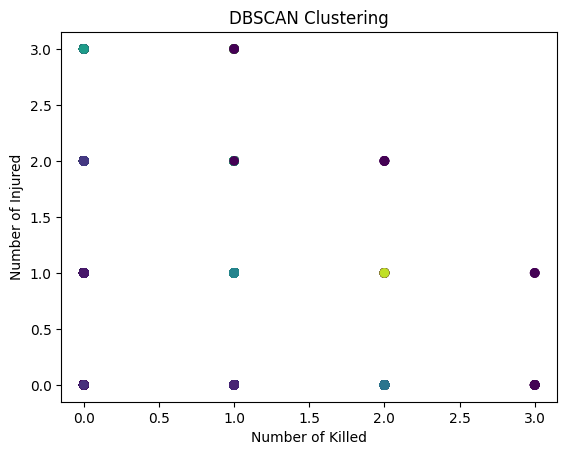

In [ ]:
# Filtra il DataFrame per lo stato dell'Illinois
df_fil = df_merged_clusterB[df_merged_clusterB['state'] == 'Illinois']

# Seleziona le colonne rilevanti per il clustering
selected_col = ['n_killed', 'n_injured', 'n_participants', 'males_to_females_ratio', 'n_participants_teen', 'min_age_participants']
Z = state_df[selected_col]

# Standardizza i dati Z-score
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(Z)

# Esegui DBSCAN
eps = 1.5  # Sostituisci con il valore appropriato
min_samples = 5  # Sostituisci con il valore appropriato
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
state_df['cluster'] = dbscan.fit_predict(Z_scaled)

# Analisi dei parametri di clustering
n_clusters = len(set(state_df['cluster'])) - (1 if -1 in state_df['cluster'] else 0)
print(f'Number of clusters: {n_clusters}')

# Caratterizzazione e interpretazione dei cluster
cluster_stats = state_df.groupby('cluster').agg({
    'n_killed': 'sum',
    'n_injured': 'sum',
    'n_participants': 'sum'
})

# Visualizzazione dei risultati
for cluster_id, row in cluster_stats.iterrows():
    print(f'Cluster {cluster_id}:')
    print(f'  Number of killed: {row["n_killed"]}')
    print(f'  Number of injured: {row["n_injured"]}')
    print(f'  Number of participants: {row["n_participants"]}')
    print('---')

# Visualizzazione della distribuzione dei cluster sulla mappa (uso solo a scopo illustrativo)
plt.scatter(state_df['n_killed'], state_df['n_injured'], c=state_df['cluster'], cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Number of Killed')
plt.ylabel('Number of Injured')
plt.show()

using distance metric, work on numerical features we remove the categorical data

In [ ]:
df_merged_clusterB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134579 entries, 0 to 134578
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       134579 non-null  datetime64[ns]
 1   state                      134579 non-null  object        
 2   city_or_county             134579 non-null  object        
 3   latitude                   134579 non-null  float64       
 4   longitude                  134579 non-null  float64       
 5   congressional_district     134579 non-null  int64         
 6   participant_age_group1     134579 non-null  category      
 7   participant_gender1        134579 non-null  category      
 8   min_age_participants       134579 non-null  int64         
 9   max_age_participants       134579 non-null  int64         
 10  n_participants_child       134579 non-null  int64         
 11  n_participants_teen        134579 non-null  int64        

Avoid the bias given by the range of the different attribute by normalization.

In [ ]:
# considering new mexico because has the greatest poverty percentage
df_newMexico = df_merged_clusterB[df_merged_clusterB['state'] == 'New Mexico']
# columns for clustering
#selected_columns = ['density_incident_state', 'males_to_females_ratio','percentage_injured','min_age_participants','max_age_participants','n_participants_child','n_participants_teen', 'n_females', 'n_killed','n_injured','n_arrested','n_unharmed','n_participants', 'unharmed_ratio']
selected_columns = ['n_killed','n_injured','n_participants','males_to_females_ratio','n_participants_teen','min_age_participants']
Y = df_newMexico[selected_columns]
# Standardizza i dati Z-score
scaler = StandardScaler()
scaler.fit(Y.values)

StandardScaler()

In [ ]:
Y.head()

,n_killed,n_injured,n_participants,males_to_females_ratio,n_participants_teen,min_age_participants
307,0,1,1,1.0,0,72
829,0,0,1,1.0,0,31
939,0,2,3,2.0,3,12
1321,1,0,3,2.0,0,28
1536,0,0,2,1.0,0,34


In [ ]:
scaler.transform(Y.head().values)

array([[-0.68148494,  1.22005356, -0.92764395, -0.68041951, -0.25264186,
         3.27433848],
       [-0.68148494, -0.63077599, -0.92764395, -0.68041951, -0.25264186,
         0.05432431],
       [-0.68148494,  3.07088311,  1.4707862 ,  0.60138451,  7.70111823,
        -1.43787738],
       [ 1.04545985, -0.63077599,  1.4707862 ,  0.60138451, -0.25264186,
        -0.18128648],
       [-0.68148494, -0.63077599,  0.27157113, -0.68041951, -0.25264186,
         0.28993511]])

In [ ]:
scaler.inverse_transform(scaler.transform(Y.head().values))

array([[ 0.,  1.,  1.,  1.,  0., 72.],
       [ 0.,  0.,  1.,  1.,  0., 31.],
       [ 0.,  2.,  3.,  2.,  3., 12.],
       [ 1.,  0.,  3.,  2.,  0., 28.],
       [ 0.,  0.,  2.,  1.,  0., 34.]])

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=3)
dbscan.fit(Y)

DBSCAN(eps=0.6, min_samples=3)

Output:
* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

In [ ]:
dbscan.labels_[:6]

array([-1,  0, -1, -1, -1, -1])

size of each cluster

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88]),
 array([456,   9,   3,   4,   7,   4,   4,   6,   3,   3,   5,   7,   3,
          8,   3,   5,   3,   5,   4,   6,   3,   8,   6,   6,   3,   7,
          3,   3,   3,   3,   3,  15,   7,   7,   5,   5,   3,   4,   5,
          5,  10,   8,   4,   8,   4,   5,   3,   3,   5,   3,   4,   3,
          5,   7,   4,  13,   3,   4,   8,   9,   3,   3,  10,   3,   4,
          3,   3,   3,   3,   3,   4,   9,   3,   4,   7,   3,   3,   3,
          3,   5,   6,   8,   3,   7,   3,   4,   3,   3,   3,   5]))

Cluster visualization in 2 dim

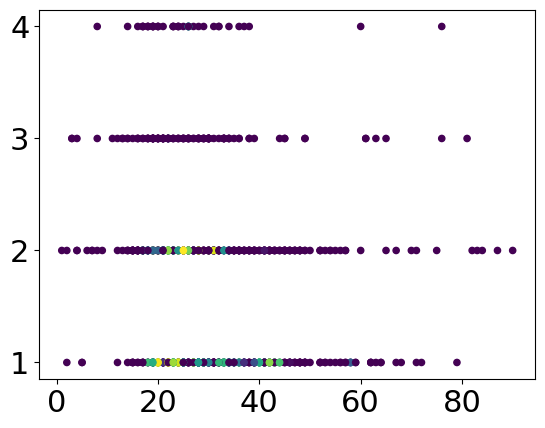

In [ ]:
plt.scatter(Y['min_age_participants'], Y['n_participants'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

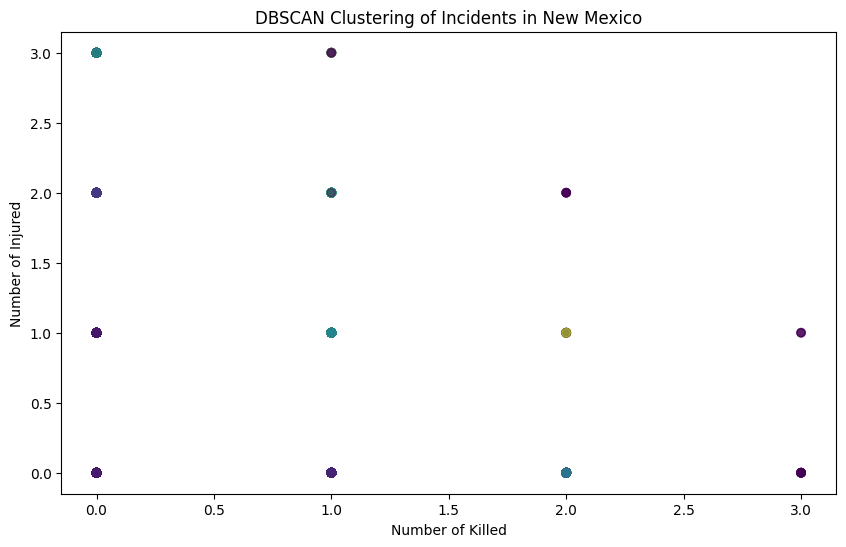

In [ ]:
col = ['n_killed', 'n_injured', 'n_participants', 'males_to_females_ratio', 'n_participants_teen', 'min_age_participants','latitude','longitude']
df_state = df_merged_clusterB[df_merged_clusterB['state'] == 'New Mexico'][col]

# Standardizza i dati Z-score
scaler = StandardScaler()
state_df_scaled = scaler.fit_transform(df_state)

# Esegui DBSCAN
eps = 0.5  # Sostituisci con il valore appropriato
min_samples = 5  # Sostituisci con il valore appropriato
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_state['cluster'] = dbscan.fit_predict(state_df_scaled)

# Visualizza i risultati
plt.figure(figsize=(10, 6))
plt.scatter(state_df['n_killed'], state_df['n_injured'], c=state_df['cluster'], cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering of Incidents in New Mexico')
plt.xlabel('Number of Killed')
plt.ylabel('Number of Injured')
plt.show()

In [ ]:
def run_dbscan_clustering(df, state, eps=0.2, min_samples=3):
    # Filtra il DataFrame per lo stato specificato
    state_df = df[df['state'] == state]

    # Seleziona le colonne rilevanti per il clustering
    #selected_columns = ['latitude', 'longitude','n_participants']
    selected_columns = ['n_participants', 'n_killed', 'n_injured']
    X = state_df[selected_columns]

    # Standardizza i dati Z-score
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Esegui DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    state_df['cluster'] = dbscan.fit_predict(X_scaled)

    # Analisi dei parametri di clustering
    n_clusters = len(set(state_df['cluster'])) - (1 if -1 in state_df['cluster'] else 0)
    print(f'Number of clusters: {n_clusters}')

    # Caratterizzazione e interpretazione dei cluster
    cluster_stats = state_df.groupby('cluster').agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'n_killed': 'sum',
        'n_injured': 'sum',
        'n_participants': 'sum'
    })

    # Visualizzazione dei risultati
    for cluster_id, row in cluster_stats.iterrows():
        print(f'Cluster {cluster_id}:')
        print(f'  Centroid: ({row["n_killed"]}, {row["n_injured"]})')
        print(f'  Number of killed: {row["n_killed"]}')
        print(f'  Number of injured: {row["n_injured"]}')
        print(f'  Number of participants: {row["n_participants"]}')
        print('---')

    # Visualizzazione della distribuzione dei cluster sulla mappa (usa solo a scopo illustrativo)
    plt.scatter(state_df['latitude'], state_df['longitude'], c=state_df['cluster'], cmap='viridis')
    plt.title('DBSCAN Clustering')
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.show()

# Esempio di utilizzo
# run_dbscan_clustering(df_merged_clusterB, 'Illinois', eps=0.2, min_samples=5)

/tmp/ipykernel_470553/1926274680.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of clusters: 29
Cluster -1:
  Centroid: (37.0, 19.0)
  Number of killed: 37.0
  Number of injured: 19.0
  Number of participants: 64.0
---
Cluster 0:
  Centroid: (0.0, 0.0)
  Number of killed: 0.0
  Number of injured: 0.0
  Number of participants: 716.0
---
Cluster 1:
  Centroid: (0.0, 4765.0)
  Number of killed: 0.0
  Number of injured: 4765.0
  Number of participants: 4765.0
---
Cluster 2:
  Centroid: (1148.0, 0.0)
  Number of killed: 1148.0
  Number of injured: 0.0
  Number of participants: 1148.0
---
Cluster 3:
  Centroid: (0.0, 2413.0)
  Number of killed: 0.0
  Number of injured: 2413.0
  Number of participants: 4826.0
---
Cluster 4:
  Centroid: (0.0, 0.0)
  Number of killed: 0.0
  Number of injured: 0.0
  Number of participants: 1169.0
---
Cluster 5:
  Centroid: (730.0, 0.0)
  Number of killed: 730.0
  Number of injured: 0.0
  Number of participants: 1460.0
---
Cluster 6:
  Centroid: (0.0, 550.0)
  Number of killed: 0.0
  Number of injured: 550.0
  Number of participants: 

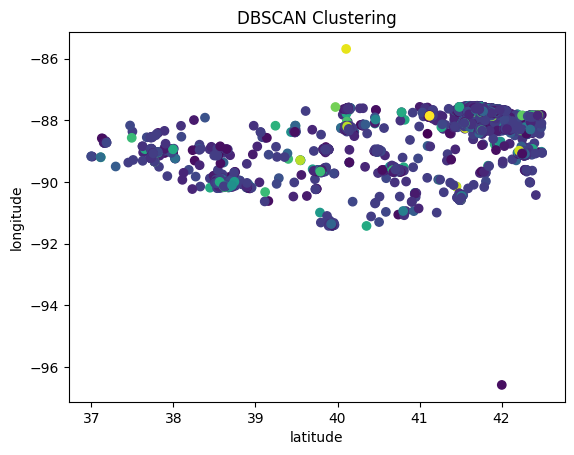

In [ ]:
run_dbscan_clustering(df_merged_clusterB, 'Illinois', eps=0.4, min_samples=7)